In [235]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
import joblib
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from pprint import pprint

In [149]:
%matplotlib inline

# Define measurement

In [163]:
def rmse(y_true, y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    return rmse

In [164]:
def lcc(y_true, y_pred):
    lcc, _ = stats.pearsonr(y_true, y_pred)
    return lcc

In [165]:
def srocc(y_true, y_pred):
    srocc, _ = stats.spearmanr(y_true, y_pred)
    return srocc

In [166]:
def accuracy(y_true, y_pred):
    ratio = abs(y_true - y_pred) / y_true
    return 1 - np.mean(ratio)

In [167]:
scorer = {}
scorer['rmse'] = metrics.make_scorer(rmse, greater_is_better=False)
scorer['lcc'] = metrics.make_scorer(lcc, greater_is_better=True)
scorer['srocc'] = metrics.make_scorer(srocc, greater_is_better=True)
scorer

{'rmse': make_scorer(rmse, greater_is_better=False),
 'lcc': make_scorer(lcc),
 'srocc': make_scorer(srocc)}

# Read data

In [180]:
features = pd.read_pickle('features.pkl')
labels = pd.read_pickle('labels.pkl')

# Group CV generator

In [158]:
group_label = np.arange(len(features.index) / 3)
group_label = np.matlib.repmat(group_label,3,1)
group_label = group_label.reshape(-1,1, order='F')

In [160]:
def CV_Generator(features, labels, group_label, n=8, test_ratio=0.2):
    CV_Group = GroupShuffleSplit(n_splits=n, test_size=test_ratio, random_state=8)
    for train, test in CV_Group.split(features, labels, groups=group_label):
        yield train, test

# Parameters grid search - first round

In [183]:
parameters_grid_1st = {}

In [184]:
parameters_grid_1st['n_estimators'] = [100]
parameters_grid_1st['criterion'] = ['mse', 'mae']
parameters_grid_1st['max_depth'] = [int(x) for x in range(7, 10)]
parameters_grid_1st['min_samples_split'] = [2,3,4,5]
parameters_grid_1st['min_samples_leaf'] = [2,3,4,5]
parameters_grid_1st['max_features'] = ['auto', 'log', 'sqrt']
parameters_grid_1st['bootstrap'] = [True, False]
parameters_grid_1st['verbose'] = [0]

In [185]:
parameters_grid_1st

{'n_estimators': [100],
 'criterion': ['mse', 'mae'],
 'max_depth': [7, 8, 9],
 'min_samples_split': [2, 3, 4, 5],
 'min_samples_leaf': [2, 3, 4, 5],
 'max_features': ['auto', 'log', 'sqrt'],
 'bootstrap': [True, False],
 'verbose': [0]}

In [186]:
Reg_video = RandomForestRegressor(random_state=8, n_jobs=-1)

In [200]:
parameters_grid_search_1st = GridSearchCV(estimator = Reg_video, param_grid = parameters_grid_1st, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan, scoring = scorer, refit = 'rmse', iid=False)

In [188]:
parameters_grid_search_1st.fit(features, labels)

Fitting 8 folds for each of 576 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed:  4.7min finished


GridSearchCV(cv=<generator object CV_Generator at 0x1a2159afc0>,
       error_score=nan,
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100], 'criterion': ['mse', 'mae'], 'max_depth': [7, 8, 9], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4, 5], 'max_features': ['auto', 'log', 'sqrt'], 'bootstrap': [True, False], 'verbose': [0]},
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score=True,
       scoring={'rmse': make_scorer(rmse, greater_is_better=False), 'lcc': make_scorer(lcc), 'srocc': make_scorer(srocc)},
       verbose=1)

In [189]:
parameters_grid_search_1st.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 100,
 'verbose': 0}

# Parameters grid search - second round

In [211]:
parameters_grid_2nd = {}

In [212]:
parameters_grid_2nd['n_estimators'] = [100]
parameters_grid_2nd['criterion'] = ['mse']
parameters_grid_2nd['max_depth'] = [8]
parameters_grid_2nd['min_samples_split'] = [int(x) for x in range(5, 20)]
parameters_grid_2nd['min_samples_leaf'] = [3]
parameters_grid_2nd['max_features'] = ['auto']
parameters_grid_2nd['bootstrap'] = [True]
parameters_grid_2nd['verbose'] = [0]
parameters_grid_2nd['oob_score'] = [True, False]

In [213]:
parameters_grid_search_2nd = GridSearchCV(estimator = Reg_video, param_grid = parameters_grid_2nd, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan, scoring = scorer, refit = 'rmse', iid=False)

In [214]:
parameters_grid_search_2nd.fit(features, labels)

Fitting 8 folds for each of 30 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   16.1s finished


GridSearchCV(cv=<generator object CV_Generator at 0x1a2088d5c8>,
       error_score=nan,
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100], 'criterion': ['mse'], 'max_depth': [8], 'min_samples_split': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'min_samples_leaf': [3], 'max_features': ['auto'], 'bootstrap': [True], 'verbose': [0], 'oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit='rmse', return_train_score=True,
       scoring={'rmse': make_scorer(rmse, greater_is_better=False), 'lcc': make_scorer(lcc), 'srocc': make_scorer(

In [215]:
parameters_grid_search_2nd.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100,
 'oob_score': True,
 'verbose': 0}

# Parameters grid search - third round

In [222]:
parameters_grid_3rd = {}

In [223]:
parameters_grid_3rd['n_estimators'] = [int(x) for x in range(100, 1000, 10)]
parameters_grid_3rd['criterion'] = ['mse']
parameters_grid_3rd['max_depth'] = [8]
parameters_grid_3rd['min_samples_split'] = [10]
parameters_grid_3rd['min_samples_leaf'] = [3]
parameters_grid_3rd['max_features'] = ['auto']
parameters_grid_3rd['bootstrap'] = [True]
parameters_grid_3rd['verbose'] = [0]
parameters_grid_3rd['oob_score'] = [True]

In [224]:
parameters_grid_search_3rd = GridSearchCV(estimator = Reg_video, param_grid = parameters_grid_3rd, 
                          cv = CV_Generator(features, labels, group_label), n_jobs = -1, verbose = 1, return_train_score=True, 
                                      error_score = np.nan, scoring = scorer, refit = 'rmse', iid=False)

In [225]:
parameters_grid_search_3rd.fit(features, labels)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  2.3min finished


GridSearchCV(cv=<generator object CV_Generator at 0x1a2088df68>,
       error_score=nan,
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=8, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'n_estimators': [100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 6...ples_leaf': [3], 'max_features': ['auto'], 'bootstrap': [True], 'verbose': [0], 'oob_score': [True]},
       pre_dispatch='2*n_jobs', refit='rmse', retu

In [226]:
parameters_grid_search_3rd.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 130,
 'oob_score': True,
 'verbose': 0}

# Discover best training set

In [242]:
idx = 0
for train_idx, test_idx in CV_Generator(features, labels, group_label, 16, test_ratio=0.2):
    train_features = features.iloc[train_idx]
    train_labels = labels.iloc[train_idx]
    test_features = features.iloc[test_idx]
    test_labels = labels.iloc[test_idx]
    best_model = parameters_grid_search_3rd.best_estimator_.fit(train_features, train_labels)
    train_pred = best_model.predict(train_features)
    test_pred = best_model.predict(test_features)
    #label_pred_ave[test_idx] = label_pred_ave[test_idx] + test_pred
    #label_count[test_idx] = label_count[test_idx] + 1
    if idx == 5:
        final_model = best_model
        best_train_idx = train_idx
        best_test_idx = test_idx
        print('Model saved')
        #print(test_pred - test_labels)
    print('       train set            test set')
    print('RMSE', rmse(train_labels, train_pred), rmse(test_labels, test_pred))
    print('LCC', lcc(train_labels, train_pred), lcc(test_labels, test_pred))
    print('SROCC', srocc(train_labels, train_pred), srocc(test_labels, test_pred))
    print('Accuracy', accuracy(train_labels, train_pred), accuracy(test_labels, test_pred))
    print('\n')
    idx += 1

       train set            test set
RMSE 4.423788727547042 6.531665545664803
LCC 0.9352243776274342 0.8445337057774442
SROCC 0.9443169656235283 0.8272844272844273
Accuracy 0.932728095254622 0.8998566880243327


       train set            test set
RMSE 4.334452365839574 7.470458935747814
LCC 0.9256608128836751 0.870429102733881
SROCC 0.9330322359690055 0.8576576576576578
Accuracy 0.9348648825626429 0.8785489299379513


       train set            test set
RMSE 4.469206511820765 7.7338458779421035
LCC 0.9362407332918498 0.6614106420026541
SROCC 0.9438246500278263 0.7070785070785072
Accuracy 0.9343891661611267 0.88473710773594


       train set            test set
RMSE 4.062615111573338 7.740170333284821
LCC 0.9460692740275327 0.7387484653583172
SROCC 0.9472494541718395 0.744916344916345
Accuracy 0.9386769655053496 0.8802881496353266


       train set            test set
RMSE 4.233228506463554 8.203328262711143
LCC 0.9407890571652876 0.7160633524777505
SROCC 0.9438674600796266 0.70682

# Best model and performance

In [243]:
pprint(final_model.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 130,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}


In [247]:
train_features = features.iloc[best_train_idx]
train_labels = labels.iloc[best_train_idx]
test_features = features.iloc[best_test_idx]
test_labels = labels.iloc[best_test_idx]
train_pred = final_model.predict(train_features)
test_pred = final_model.predict(test_features)
print('  The accuracy of result of best model')
print('       train set            test set')
print('RMSE', rmse(train_labels, train_pred), rmse(test_labels, test_pred))
print('LCC', lcc(train_labels, train_pred), lcc(test_labels, test_pred))
print('SROCC', srocc(train_labels, train_pred), srocc(test_labels, test_pred))
print('Accuracy', accuracy(train_labels, train_pred), accuracy(test_labels, test_pred))

  The accuracy of result of best model
       train set            test set
RMSE 5.4436776110037375 2.949932111840388
LCC 0.8987714004533585 0.9617563376194712
SROCC 0.9006592747977226 0.9500643500643502
Accuracy 0.9169796990804356 0.9525696032690034


10
20
30
40
50
60
70
80
90
100


RMSE: 4.796723796869648
LCC: 0.922594467393692
SROCC: 0.9216685999203615
Accuracy 0.9287005007629306


In [138]:
feature_importance = pd.DataFrame(final_model.feature_importances_, index=features.columns, columns=['Weight'])

In [139]:
feature_importance = feature_importance.sort_values(by = 'Weight', ascending=False)

In [140]:
feature_importance

,Weight
msssim,0.380318
TA,0.181886
psnrhvsm,0.150509
SA,0.046529
Noise,0.040862
Blur,0.034587
Interlace,0.032374
Flickering,0.028311
ssim,0.022061
Exposure(bri),0.019179


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

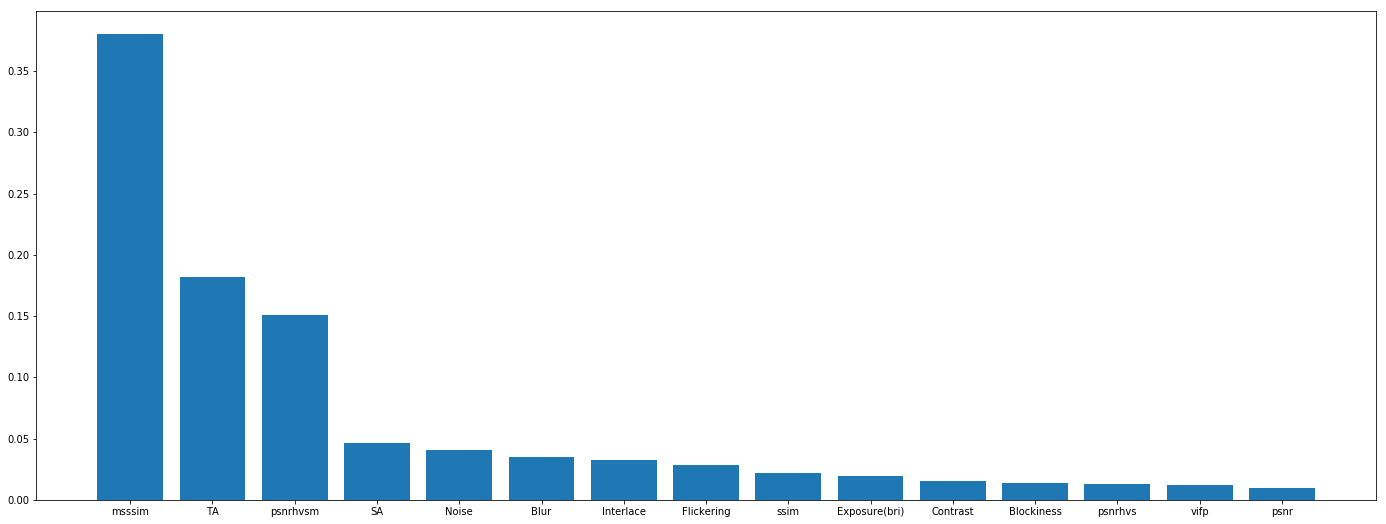

In [141]:
fig, ax = plt.subplots(figsize = (24, 9))
ax.bar(feature_importance.index, feature_importance['Weight'])
plt.tight_layout

In [142]:
features_augment = features.loc[:,['msssim', 'TA', 'psnrhvsm']]